In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.linear_model as sklinear

In [41]:
data_2020 = pd.read_csv('Måledata_mars_juli_2020.csv', index_col = 'Time')
data_2021 = pd.read_csv('Måledata_mars_juli_2021.csv',  index_col = 'Time')

In [42]:
#data for analyse
data_2020

,Irradiance (W/m2),Ambient Temperature (C),Inlet Temperature (C),Mass flow (g/s),Outlet Temperature (C)
Time,,,,,
2020-03-01 00:01:00,0.0,0.4,15.6,107.0,23.6
2020-03-01 00:02:00,0.0,0.4,15.6,107.0,23.6
2020-03-01 00:03:00,0.0,0.4,15.6,107.0,23.6
2020-03-01 00:04:00,0.0,0.4,15.6,107.0,23.6
2020-03-01 00:05:00,0.0,0.4,15.6,107.0,23.6
...,...,...,...,...,...
2020-07-31 23:55:00,-1.0,17.7,25.5,0.0,26.9
2020-07-31 23:56:00,-1.0,17.8,25.5,0.0,26.9
2020-07-31 23:57:00,-1.0,17.8,25.5,0.0,26.9


In [43]:
#krav stilt i labmanual
a93_limits = {'irr_norm_min' : 790, 
              'dif_irr_max' : 20, 
              'wind_min':2.2, 'wind_max': 4.5}

equilibrium_diff_limits = {'irr_norm' : 32, 
                   'dif_irr' : 1.5,
                   'water_in': 1,
                   'mass_flow': 2}


In [44]:
data_2020.columns

Index(['Irradiance (W/m2)', 'Ambient Temperature (C)', 'Inlet Temperature (C)',
       'Mass flow (g/s)', 'Outlet Temperature (C)'],
      dtype='object')

In [45]:
# Krav som er i data
limits = {'irr_min' : a93_limits['irr_norm_min']}

diff_limits = {'irr_norm' : 32,
               'amb_temp': 1.5,
               'water_temp_in': 1,
               'mass_flow': 2}

In [46]:
def find_intervals(df, limits, diff_limits, period= 15):
    """
    period: minutes
    df: dataframe, each step is a minute
    limits: dictionary of countinous limits
    diff_limits: dictionary of limits of variation in interval
    """
    #continual limit
    irr_min_lim = limits['irr_min']
    
    #variance limits
    irr_diff_lim = diff_limits['irr_norm']
    T_amb_diff_lim = diff_limits['amb_temp']
    T_wtr_diff_lim = diff_limits['water_temp_in']
    flow_diff_lim = diff_limits['mass_flow']
    
    #initialization
    
    #list of valid intervals
    intervals = []
    #Temporary storage for current interval
    interval = []
    #index
    i = 0
    #valid interval length tracker
    interval_len = 0
    
    #loop
    while i < len(df.index):     
        
        irr = df.iloc[i]['Irradiance (W/m2)']     
        if irr > irr_min_lim:
            # Appends datapoint to current interval if irradiance treshold met
            interval.append(i)
            interval_len += 1
        else:
            # counter and current interval
            interval_len = 0
            interval = []
            
        if interval_len == 15:
            #At this point we have an interval of 15 points meeting point thresholds (Irradiance)
            irr_vals = df.iloc[interval]['Irradiance (W/m2)']
            T_amb_vals = df.iloc[interval]['Ambient Temperature (C)']
            T_wtr_vals = df.iloc[interval]['Inlet Temperature (C)']
            flow_vals = df.iloc[interval]['Mass flow (g/s)']
            
            # 2 percent deviation from interval flow mean allowed
            flow_mean = np.mean(flow_vals)
            flow_max_lim = flow_mean + flow_mean/50
            flow_min_lim = flow_mean - flow_mean/50
            flow_max = np.max(flow_vals)
            flow_min = np.min(flow_vals)
            
            # Checking variation limit for temperature and irradiance
            irr_var = np.max(irr_vals) - np.min(irr_vals)
            T_amb_var = np.max(T_amb_vals) - np.min(T_amb_vals)
            T_wtr_var = np.max(T_wtr_vals) - np.min(T_wtr_vals)
            
            # Datavalues in interval has to meet all conditions to be eligible
            if (irr_var <= irr_diff_lim)\
            and (T_amb_var <= T_amb_diff_lim)\
            and (T_wtr_var <= T_wtr_diff_lim)\
            and (flow_max <= flow_max_lim)\
            and (flow_min >= flow_min_lim)\
            and (flow_min >= 0.1):
                #appends it to valid intervals if all conditions are met
                intervals.append(interval)
                
            #empties list of valid datapoints and resets counter of valid length
            interval = []
            interval_len = 0                
                
        i += 1
            
    return intervals
            

In [47]:
intervals_2020_indexes = find_intervals(data_2020, 
                           limits=limits, 
                           diff_limits=diff_limits,
                           period=15)


In [48]:
len(intervals_2020_indexes)

416

In [49]:
#Irradiance spelled differently in the columns of the datasets, code needs slight changes to run 2021 data
#
#intervals_2020_indexes = find_intervals(data_2020, 
#                           limits=limits, 
#                           diff_limits=diff_limits,
#                           period=15)

In [51]:
#Converting the list of indexes into a filtered dataset, taking the mean of each 15 min interval as a datapoint
filtered_data_2020 = pd.DataFrame(columns=data_2020.columns)

for indexes, i in zip(intervals_2020_indexes, range(len(intervals_2020_indexes))):
    new_row = {}
    for column in data_2020.columns:
        new_values = data_2020[column].iloc[indexes].mean(axis=0)
        #print(column)
        #print(data_2020[column].iloc[indexes])
        #print(new_values)
        #print('\n')
        new_row[column] = new_values
        #print(new_row[column])
        #print('\n')
    new_row = pd.DataFrame(new_row, index = [data_2020.index[intervals_2020_indexes[i][0]]])
    #print(new_row)
    #print('\n')
    filtered_data_2020 = pd.concat([filtered_data_2020, new_row], axis=0) 

In [52]:
##Converting the list of indexes into a filtered dataset
#filtered_data_2020 = pd.DataFrame(columns=data_2020.columns)
#
#for i in intervals_2020_indexes:
#    filtered_data_2020 = pd.concat([filtered_data_2020, data_2020.iloc[i]]) 
#

In [53]:
filtered_data_2020.to_csv('Måledata_mars_juli_2020_filtered.csv')

In [54]:

Ac = 67.2 #m^2

taualfa = 0.83*0.95

Cp = 4.184 #Joulse/K/g

#Calculating Efficiency and storing it as a column
filtered_data_2020['Efficiency'] = (Cp*filtered_data_2020['Mass flow (g/s)']*(filtered_data_2020['Outlet Temperature (C)'] - filtered_data_2020['Inlet Temperature (C)']))/(Ac*filtered_data_2020['Irradiance (W/m2)'])


In [55]:
filtered_data_2020

,Irradiance (W/m2),Ambient Temperature (C),Inlet Temperature (C),Mass flow (g/s),Outlet Temperature (C),Efficiency
2020-03-14 10:51:00,803.866667,1.786667,14.740000,321.066667,32.743333,0.447699
2020-03-14 11:21:00,839.733333,2.213333,14.866667,302.600000,34.640000,0.443639
2020-03-14 11:43:00,845.400000,2.460000,15.000000,291.133333,35.350000,0.436331
2020-03-14 11:58:00,847.133333,2.513333,15.013333,286.266667,35.866667,0.438750
2020-03-16 12:18:00,812.533333,6.526667,15.060000,301.066667,35.773333,0.477853
...,...,...,...,...,...,...
2020-07-22 11:53:00,955.933333,17.593333,20.993333,392.733333,42.150000,0.541178
2020-07-22 13:13:00,1002.666667,19.006667,21.326667,407.400000,43.660000,0.564990
2020-07-22 13:28:00,1007.400000,19.240000,21.533333,401.866667,43.950000,0.556767
2020-07-25 10:33:00,808.866667,18.006667,20.560000,409.200000,37.163333,0.522970


In [56]:
x = (filtered_data_2020['Inlet Temperature (C)']- filtered_data_2020['Ambient Temperature (C)'] )/(filtered_data_2020['Irradiance (W/m2)'])

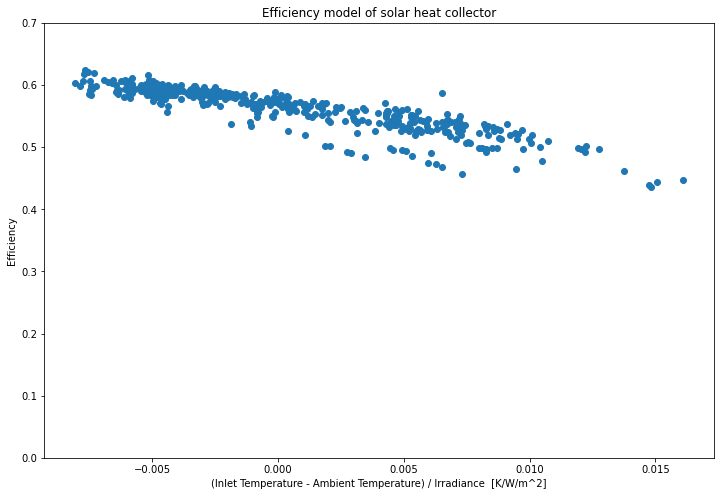

In [57]:

fig, ax = plt.subplots(figsize = (12, 8))
ax.set_ylim(0,0.7)
ax.set_title('Efficiency model of solar heat collector')
ax.set_ylabel('Efficiency')
ax.set_xlabel('(Inlet Temperature - Ambient Temperature) / Irradiance  [K/W/m^2]')
ax.plot(x, filtered_data_2020['Efficiency'], marker='o', linestyle='')

In [58]:
linreg = sklinear.LinearRegression().fit(x.values.reshape(-1, 1), filtered_data_2020['Efficiency'])

In [59]:
y_pred = linreg.predict(x.values.reshape(-1, 1))

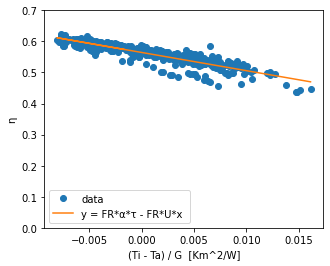

In [60]:
fig, ax = plt.subplots(figsize = (5, 4))
ax.set_ylim(0,0.7)
# ax.set_title('Thermal efficiency regression')
ax.set_ylabel('η')
ax.set_xlabel('(Ti - Ta) / G  [Km^2/W]')
ax.plot(x, filtered_data_2020['Efficiency'], marker='o', linestyle='', label= 'data')
ax.plot(x, y_pred, linestyle='-', label = 'y = FR*α*τ - FR*U*x ')
plt.legend(loc = 'lower left')
plt.savefig('Efficiency_model.pdf')

In [61]:
linreg.score(x.values.reshape(-1, 1), filtered_data_2020['Efficiency'])

0.7948234935551545

In [62]:
zero = np.array([0])

In [63]:
intercept = linreg.predict(zero.reshape(1, -1))

In [64]:
stigning = linreg.coef_

In [65]:
taualfa = 0.83 * 0.95

FRUL = -stigning

FRtaualfa = intercept

UL = FRUL/(FRtaualfa/taualfa)

FR = FRtaualfa/taualfa


__MOdell Resultater__

In [66]:
FRtaualfa

array([0.56449417])

In [67]:
FR

array([0.7159089])

In [68]:
UL

array([8.19500415])

In [69]:
FR*UL

array([5.86687644])

In [70]:
y_pred = linreg.predict(x.values.reshape(-1, 1))

__MOdell 2__

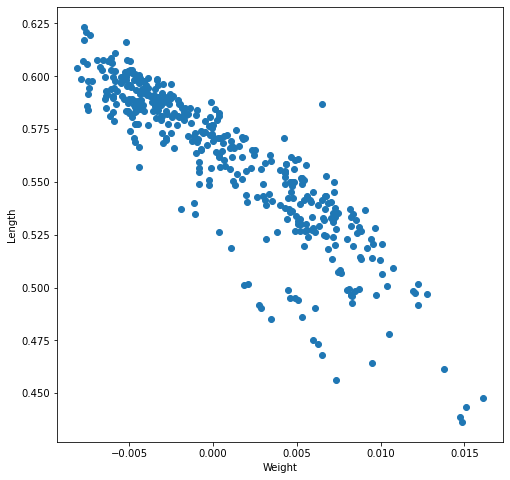

In [74]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.stats import t as t_dbn
from scipy.stats import norm as normal_dbn

X = x
Y = filtered_data_2020['Efficiency'].values
f = plt.figure(figsize=(8,8))
ax = f.gca()
ax.scatter(X, Y)
ax.set_xlabel('Weight')
ax.set_ylabel('Length');

In [75]:
def fit_least_squares(X, Y):
    
    X = np.asarray(X)
    n = X.shape[0]
    Y = np.asarray(Y)
    X_bar = np.mean(X)
    Y_bar = np.mean(Y)
    
    beta_hat_1 = (np.sum((X - X_bar) * (Y - Y_bar)) / 
                  np.sum((X - X_bar)**2))
    beta_hat_0 = Y_bar - beta_hat_1 * X_bar
    
    resid = Y - beta_hat_0 - beta_hat_1 * X
    sigma_hat = np.sqrt(np.sum(resid**2) / (n - 2))
    
    return np.array([beta_hat_0, beta_hat_1]), sigma_hat, resid

In [76]:
results = fit_least_squares(X, Y)
results[0], results[1]

(array([ 0.56449417, -5.86687644]), 0.016028255096936724)

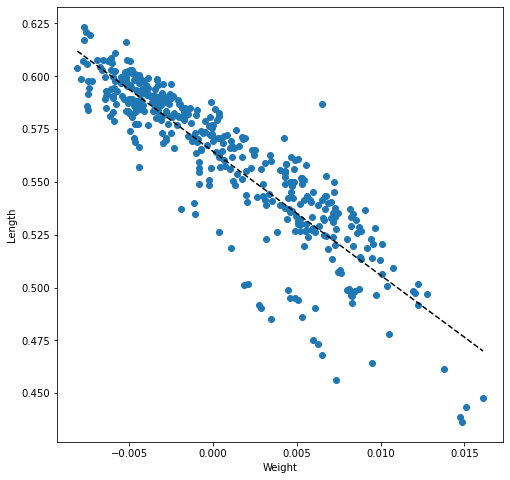

In [77]:
X_min, X_max = X.min(), X.max()
beta_hat_0, beta_hat_1 = results[0]
Y_max = beta_hat_0 + beta_hat_1 * X_max
Y_min = beta_hat_0 + beta_hat_1 * X_min

ax.plot([X_min, X_max], [Y_min, Y_max], 'k--')
f

In [78]:
def compute_std(X, Y, results, linear_comb):
    beta_hat, sigma_hat, resid = results
    X = np.asarray(X)
    X_bar = X.mean()
    
    n = X.shape[0]
    a, b = linear_comb

    var = sigma_hat**2 * ((a**2)/n + (b - a * X_bar)**2 / np.sum((X - X_bar)**2))
    
    return np.sqrt(var)

X_bar = np.mean(X)

print('SD(beta_hat_1): ', compute_std(X, Y, results, [0, 1]), results[1] / np.sqrt(np.sum((X - X_bar)**2)))
print('SD(beta_hat_0): ', compute_std(X, Y, results, [1, 0]))


SD(beta_hat_1):  0.14649919529202687 0.14649919529202687
SD(beta_hat_0):  0.0007919011103104905


In [79]:
taualfa = 0.83 * 0.95

FRUL2 = -beta_hat_1

FRtaualfa2 = beta_hat_0

UL2 = FRUL/(FRtaualfa/taualfa)

FR2 = FRtaualfa/taualfa

In [80]:
print(FRUL, FRUL2)
print(FR, FR2)
print(UL, UL2)

[5.86687644] 5.866876444245139
[0.7159089] [0.7159089]
[8.19500415] [8.19500415]


Errors


In [81]:
# from scipy.stats import t
# 
# s_1= compute_std(X, Y, results, [0, 1])
# s_0 =  compute_std(X, Y, results, [1, 0])
# 
# 
# beta0_95_min = beta_hat_0 - 0.25
# m = np.mean(X)
# dof = len(x-1)
# confidence = 0.95
# t_crit = np.abs(t.ppf((1-confidence)/2,dof))
# x_m = [(x - m)**2 for x in X]
# X_min = X.min()
# 
# p2 = np.sqrt((1/dof)+(X_min-m)**(2)/(np.sum(x_m)))
# 
# beta0_uncertainty = t_crit * s_0
# 
# beta1_uncertainty = t_crit * (s_1)/(np.sum(x_m))

In [82]:
# beta0_uncertainty

0.0015566264749162727

In [83]:
#beta1_uncertainty

24.05728906422803

In [54]:
# quantile = t_dbn.ppf(0.975, len(x))
# SD_beta_hat_1= compute_std(X, Y, results, [0, 1])
# uncertainty_beta_hat_1 = quantile * SD_beta_hat_1
# uncertainty_beta_hat_1

0.2879709637685521

_3.2 Test av modell_


In [171]:
#Calculating energy production, efficiency and x variable for prediction
data_2021 = pd.read_csv('Måledata_mars_juli_2021.csv',index_col = 'Time')
data_2021.index = pd.to_datetime(data_2021.index)
data_2021.rename(columns = {'Irradience (W/m2)':'Irradiance (W/m2)'}, inplace = True)
data_2021['Irradiance (W/m2)'].dropna(inplace=True)
data_2021 = data_2021[data_2021['Mass flow (g/s)'] > 0]
data_2021 = data_2021[data_2021['Irradiance (W/m2)'] > 0]
data_2021

,Irradiance (W/m2),Ambient Temperature (C),Inlet Temperature (C),Mass flow (g/s),Outlet Temperature (C)
Time,,,,,
2021-03-04 09:46:00,547.0,1.2,17.3,326.0,18.35
2021-03-04 09:47:00,550.0,1.2,16.9,320.0,18.30
2021-03-04 09:48:00,552.0,1.3,16.3,260.0,18.35
2021-03-04 09:49:00,554.0,1.3,16.0,239.0,26.60
2021-03-04 09:50:00,558.0,1.3,15.9,220.0,40.00
...,...,...,...,...,...
2021-07-31 17:44:00,147.0,18.7,26.5,155.0,31.50
2021-07-31 17:45:00,147.0,18.7,27.0,120.0,31.25
2021-07-31 17:46:00,145.0,18.7,27.9,96.0,30.95


In [223]:
taualfa = 0.83*0.95

data_2021['Q'] = Cp*data_2021['Mass flow (g/s)']*(data_2021['Outlet Temperature (C)'] - data_2021['Inlet Temperature (C)'])

data_2021['efficiency_pred'] =  FR*taualfa - FR*UL*((data_2021['Inlet Temperature (C)'] - data_2021['Ambient Temperature (C)'])/data_2021['Irradiance (W/m2)'])
data_2021['Q_pred'] = Ac*data_2021['efficiency_pred'].multiply(data_2021['Irradiance (W/m2)'], axis = 'index')
data_2021['Q_naive'] =data_2021['Irradiance (W/m2)'].multiply(0.5 * Ac, axis = 'index')

data_2021['Power produced'] = data_2021['Q']*60/3600000
data_2021['Power predicted'] = data_2021['Q_pred']*60/3600000
data_2021['Power naive'] = data_2021['Q_naive']*60/3600000


In [232]:

y_pred = (data_2021['Power predicted'][data_2021['Q'] > 0]).resample('D').sum()
y_truth = (data_2021['Power produced'][data_2021['Q'] > 0]).resample('D').sum()
y_naive = (data_2021['Power naive'][data_2021['Q'] > 0]).resample('D').sum()


model_mean_abs_rel_error_2021 = abs((y_pred - y_truth)/y_truth).sum()/len(y_pred)
naive_mean_abs_rel_error_2021 = abs((y_naive - y_truth)/y_truth).sum()/len(y_pred)

model_abs_rel_error_2021 = abs((y_pred - y_truth)/y_truth)
naive_abs_rel_error_2021 = abs((y_naive - y_truth)/y_truth)
  

In [234]:
naive_mean_abs_rel_error_2021

0.11598913383661305

In [235]:
model_mean_abs_rel_error_2021

0.053799537566731934

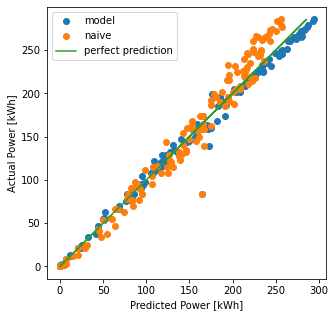

In [252]:
plt.figure(figsize=(5,5))
plt.plot(y_pred, y_truth, marker= 'o', linestyle='', label='model' )
plt.plot(y_naive, y_truth, marker= 'o', linestyle='' , label = 'naive')
plt.plot(y_truth, y_truth, label = 'perfect prediction')
plt.legend()
#plt.xlim(0,1.75*1e7)
#plt.ylim(0,1.75*1e7)
# plt.title('Prediciton of daily energy')
plt.ylabel('Actual Power [kWh]')
plt.xlabel('Predicted Power [kWh]')
#plt.yscale('log')
#plt.xscale('log')
plt.savefig('Prediction.pdf')


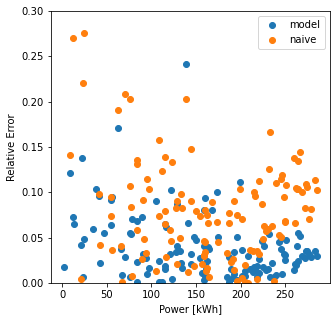

In [239]:
plt.figure(figsize=(5,5))
plt.plot(y_truth, model_abs_rel_error_2021, marker= 'o', linestyle='', label='model' )
plt.plot(y_truth, naive_abs_rel_error_2021, marker= 'o', linestyle='' , label = 'naive')
plt.legend()
#plt.xlim(0,1.75*1e7)
plt.ylim(0,0.3)
#plt.title('Error of prediciton of daily energy')
plt.ylabel('Relative Error')
plt.xlabel('Power [kWh]')
plt.savefig('relative_error.pdf')
